## TW8: Neural Networks
* Xiaomei Xie
* Lili Hao

### Set up

In [50]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_blobs

from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [35]:
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = int(np.amax(y)) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses+1])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses+1])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = int(np.amax(y)) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()
    

## Part 0

### Neural networks: Classification


- We will work on some of cells togeter

- Understand the results

### Activation functions

In [3]:
xrange = np.linspace(-2, 2, 200)
print(xrange)

[-2.         -1.9798995  -1.95979899 -1.93969849 -1.91959799 -1.89949749
 -1.87939698 -1.85929648 -1.83919598 -1.81909548 -1.79899497 -1.77889447
 -1.75879397 -1.73869347 -1.71859296 -1.69849246 -1.67839196 -1.65829146
 -1.63819095 -1.61809045 -1.59798995 -1.57788945 -1.55778894 -1.53768844
 -1.51758794 -1.49748744 -1.47738693 -1.45728643 -1.43718593 -1.41708543
 -1.39698492 -1.37688442 -1.35678392 -1.33668342 -1.31658291 -1.29648241
 -1.27638191 -1.25628141 -1.2361809  -1.2160804  -1.1959799  -1.1758794
 -1.15577889 -1.13567839 -1.11557789 -1.09547739 -1.07537688 -1.05527638
 -1.03517588 -1.01507538 -0.99497487 -0.97487437 -0.95477387 -0.93467337
 -0.91457286 -0.89447236 -0.87437186 -0.85427136 -0.83417085 -0.81407035
 -0.79396985 -0.77386935 -0.75376884 -0.73366834 -0.71356784 -0.69346734
 -0.67336683 -0.65326633 -0.63316583 -0.61306533 -0.59296482 -0.57286432
 -0.55276382 -0.53266332 -0.51256281 -0.49246231 -0.47236181 -0.45226131
 -0.4321608  -0.4120603  -0.3919598  -0.3718593  -0.

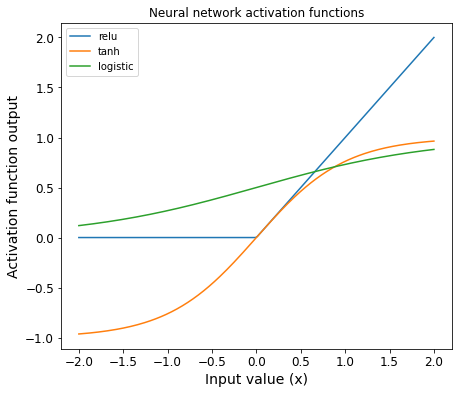

In [4]:


plt.figure(figsize=(7,6))

# three commonly used activation functions, relu, tanh, and logistic
plt.plot(xrange, np.maximum(xrange,0),label='relu')
plt.plot(xrange, np.tanh(xrange),label='tanh')
plt.plot(xrange, 1/(1+np.exp(-xrange)), label='logistic')

plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

### Synthetic dataset 1: single hidden layer

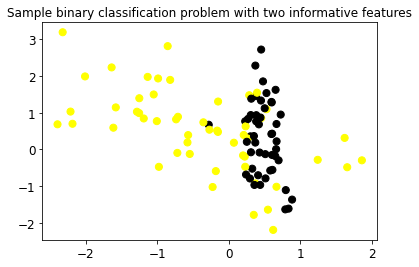

In [5]:
# synthetic dataset for classification (binary)
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)

plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o', c=y_C2, s=50, cmap=cmap_bold)
plt.show()

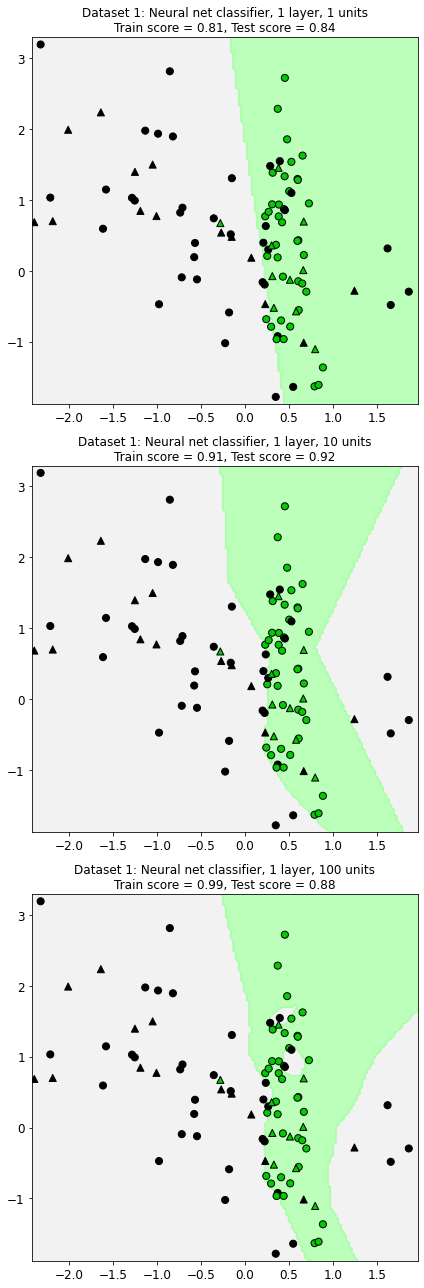

In [9]:
# MLPclassifier
from sklearn.neural_network import MLPClassifier


fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# split the data

X_train,X_test,y_train,y_test = train_test_split(X_C2,y_C2, random_state=0)


for units, axis in zip([1,10,100],subaxes):
    
    # model training with one hidden layer
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver = 'lbfgs', random_state=0).fit(X_train, y_train)
    
    
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Synthetic dataset 2: single hidden layer

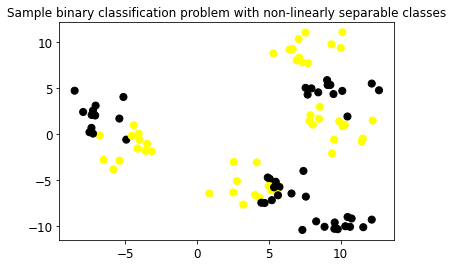

In [10]:
# more difficult synthetic dataset for classification (binary)
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


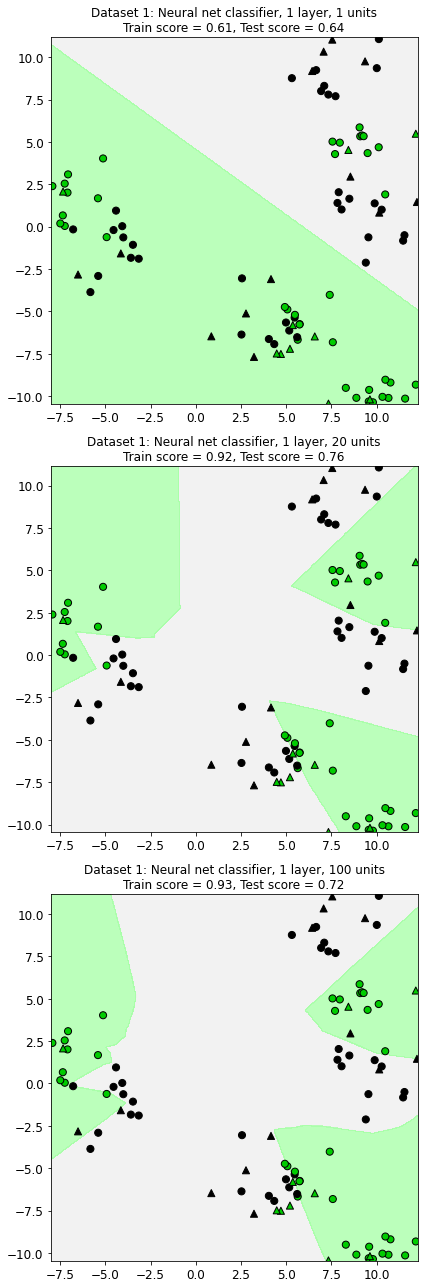

In [11]:
from sklearn.neural_network import MLPClassifier

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

for units, axis in zip([1, 20, 100], subaxes):
    # model training with one hidden layer
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver = 'lbfgs', random_state=0).fit(X_train, y_train)  
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Synthetic dataset 2: two hidden layers

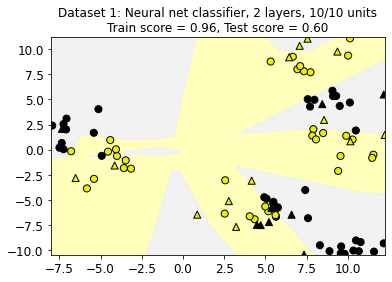

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

# model training with two hidden layers
nnclf = MLPClassifier(hidden_layer_sizes = [10, 10], solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)


plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

In [13]:
X_train.shape

(75, 2)

#### Regularization parameter: alpha

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

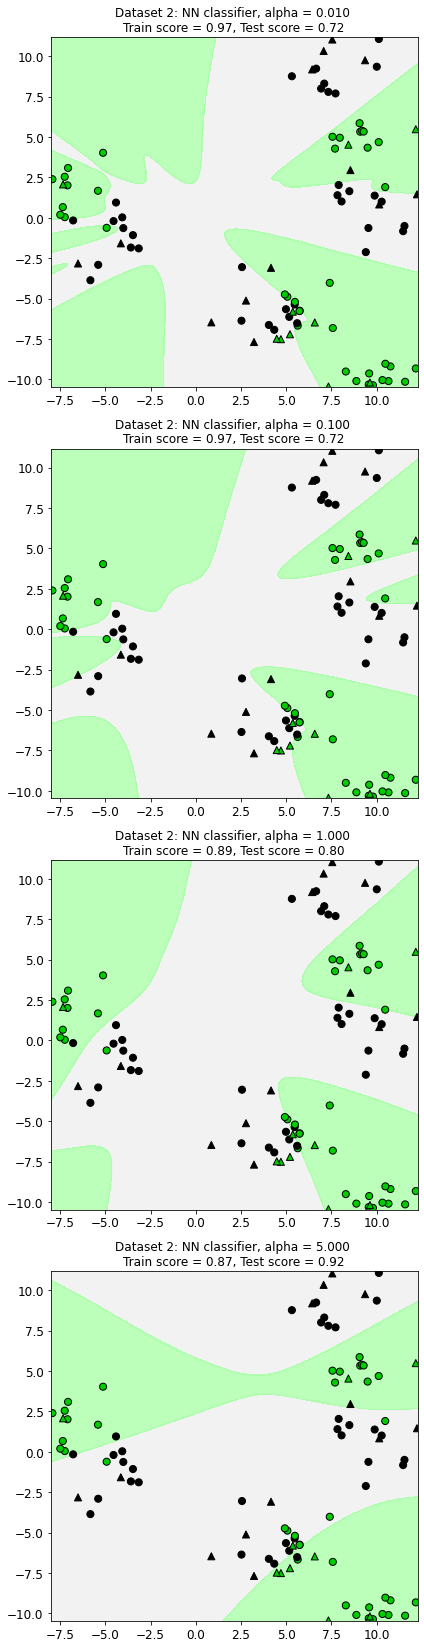

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    # training the data
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train) 
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    

#### The effect of different choices of activation function

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

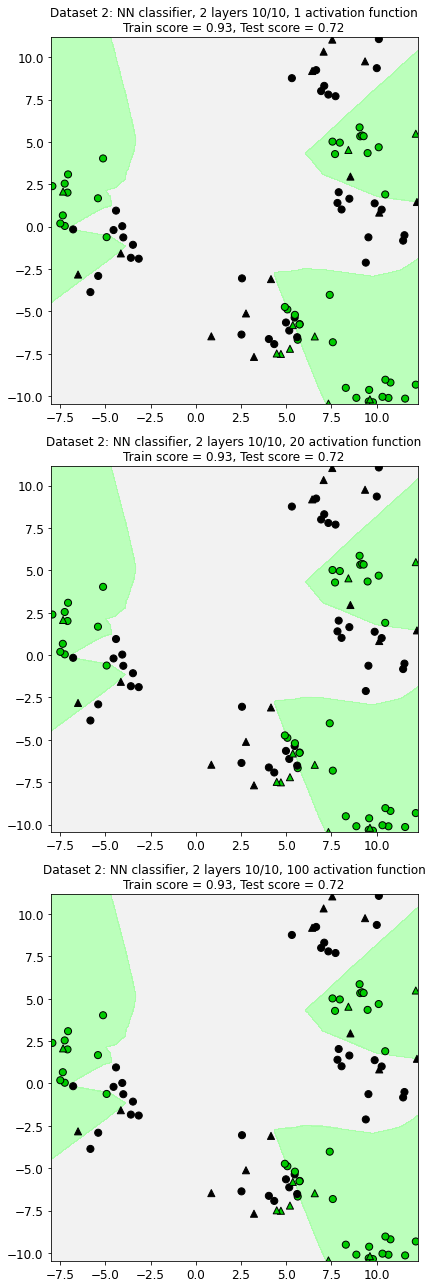

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for this_activation, axis in zip([1,20,100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver = 'lbfgs', random_state=0).fit(X_train, y_train) 
        
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
activation function'.format(this_activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Neural networks: Regression

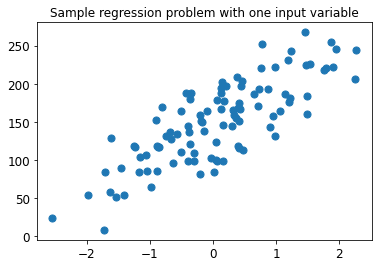

In [16]:
# synthetic dataset for simple regression
from sklearn.datasets import make_regression

plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

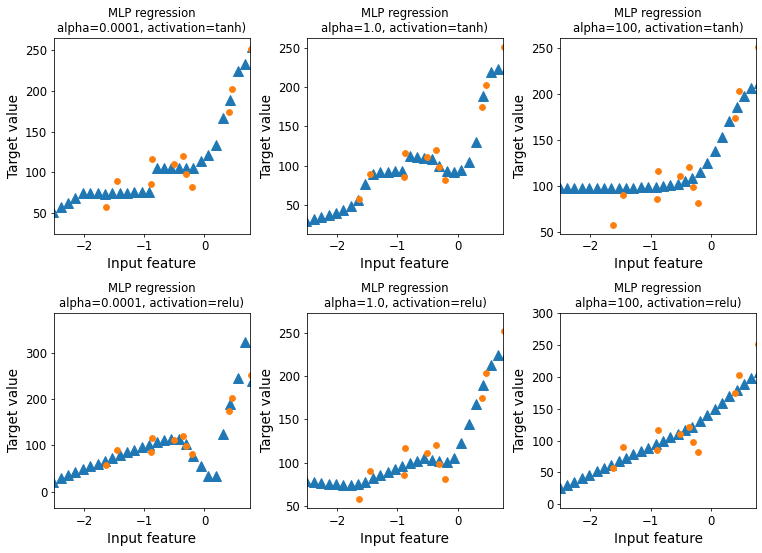

In [17]:
from sklearn.neural_network import MLPRegressor

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()

# TW 9

## Part 1

### Application to real-world dataset for classification

1. Breast cancer dataset

2. Fruit dataset

For each dataset, 

- apply neural network with 2 hidden layers with varying number of units (10, 20, 50, 100). 

- find out the optimla alpha parameter value for regularization. 

- apply different activation functions (logistic, tanh, relu) and show the effect.

- compare the results without scaling and with scaling. 


### 1. Breast Cancer dataset

### Apply neural network with 2 hidden layers with varying number of units (10, 20, 50, 100). 

### Find out the optimla alpha parameter value for regularization. 

### Apply different activation functions (logistic, tanh, relu) and show the effect. 

### Compare the results without scaling and with scaling. 

### 2. Fruit dataset

In [18]:
data = pd.read_csv('./data/fruit_data_with_colors.txt', sep="\t")
data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [19]:
data.columns

Index(['fruit_label', 'fruit_name', 'fruit_subtype', 'mass', 'width', 'height',
       'color_score'],
      dtype='object')

In [20]:
col = ['fruit_label', 'mass', 'width', 'height',
       'color_score']

In [21]:
dataset = data[col].values

In [23]:
X = dataset[:,2:4]
#y = dataset[:,4]
#y = np.asarray(dataset[:,4]) #, dtype="|S6"
y= list(dataset[:,4])

In [25]:
type(y) 

list

In [26]:
int(np.amax(y) )

0

In [27]:
#X = X.to_numpy()
print(type(X))

#y = y.to_numpy()
print(type(y))

<class 'numpy.ndarray'>
<class 'list'>


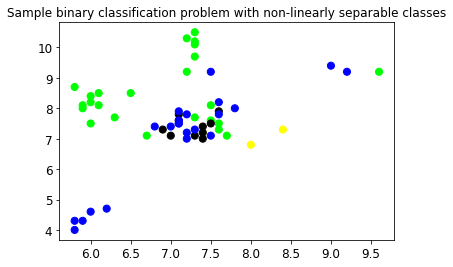

In [39]:
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X[:,0], X[:,1], c=y,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

### Apply neural network with 1 hidden layers with varying number of units (10, 20, 50, 100).

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33) #test_size=0.33, random_state=4


In [31]:
# model training with two hidden layers
#nnclf = MLPClassifier(hidden_layer_sizes = (30,30,30), solver='lbfgs').fit(X_train, y_train)

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=[50,50], solver='lbfgs').fit(X_train, y_train)

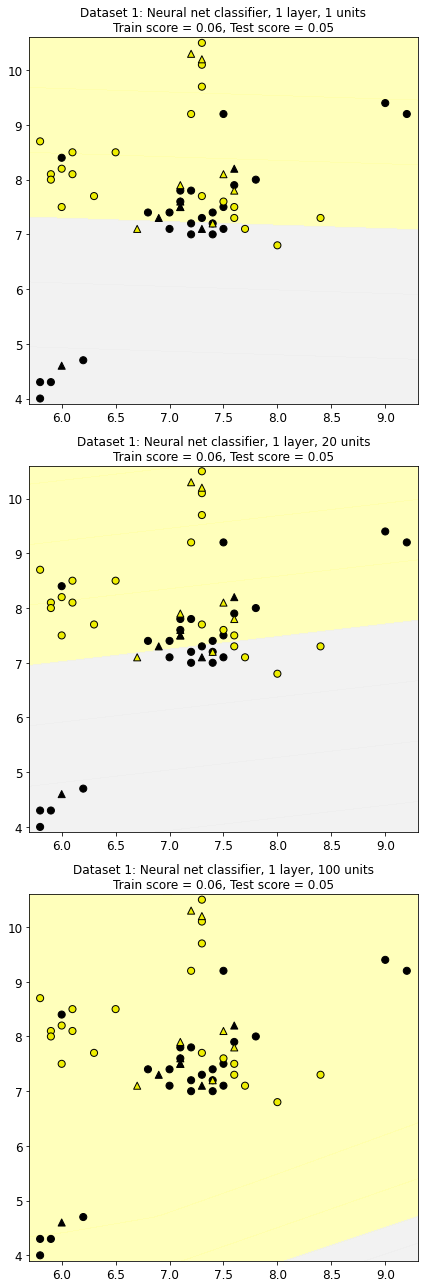

In [40]:
from sklearn.neural_network import MLPClassifier

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

for units, axis in zip([1, 20, 100], subaxes):
    # model training with one hidden layer
    nnclf =MLPRegressor(hidden_layer_sizes = [units], solver = 'lbfgs', random_state=0).fit(X_train, y_train)  
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

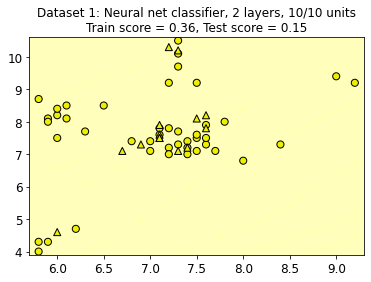

In [37]:
plot_class_regions_for_classifier(mlp, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

### Apply neural network with 2 hidden layers with varying number of units (10, 20, 50, 100).

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor


C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


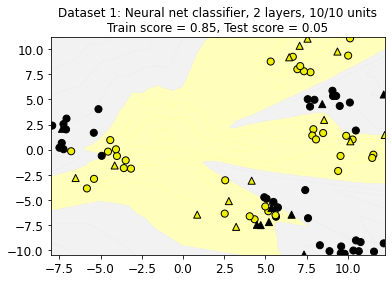

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

# model training with two hidden layers
nnclf = MLPRegressor(hidden_layer_sizes = [10,20,50,100], solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)


plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

### find out the optimla alpha parameter value for regularization.

In [43]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=0)

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Saving figure NN_basic_regularization_alpha_0.010


C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Saving figure NN_basic_regularization_alpha_0.100


C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Saving figure NN_basic_regularization_alpha_1.000


C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Saving figure NN_basic_regularization_alpha_5.000


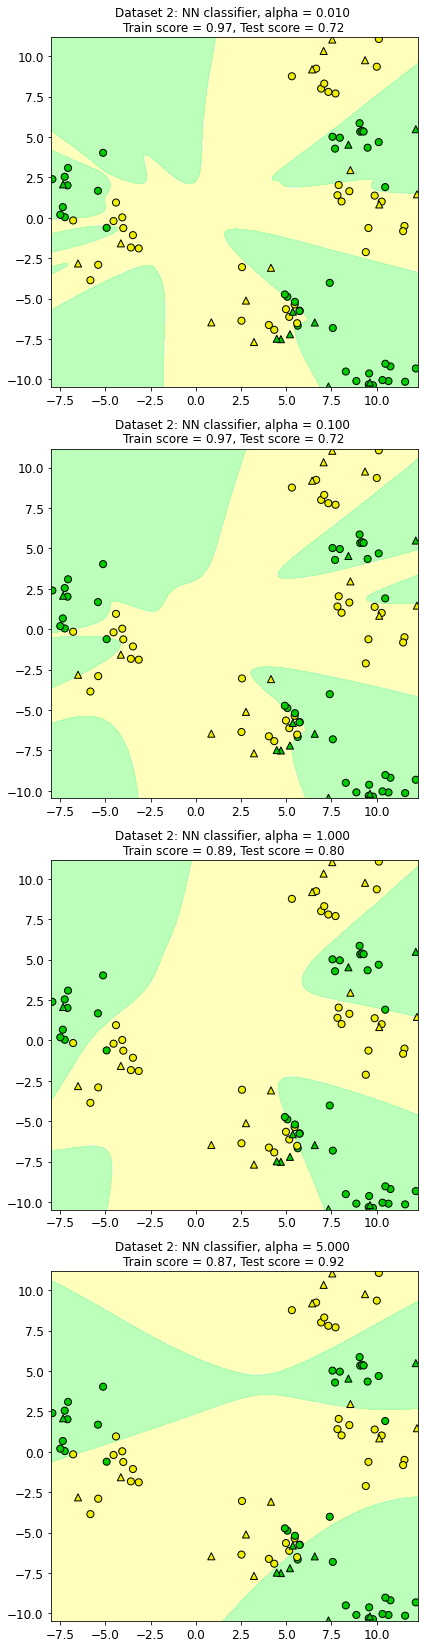

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    # training the data
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train) 
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    save_fig('NN_basic_regularization_alpha_{:.3f}'.format(this_alpha))

In [63]:
train_scores_mean = []
test_scores_mean = []

alpha_sizes = [0, 0.0001, 0.001, 0.01, 0.02, 0.05, 0.075, 0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7,0.8,0.9, 1,2,5]

for this_alpha in alpha_sizes:
    mlp_poly = MLPRegressor(hidden_layer_sizes = [10,20,50,100],alpha=this_alpha, solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)
    r2_train = mlp_poly.score(X_train, y_train)
    r2_test = mlp_poly.score(X_test, y_test)
    print('Alpha = {:.2f}\
\nr-squared training: {:.2f}, \nr-squared test: {:.2f}'
         .format(this_alpha, r2_train, r2_test))
    
    y_pred = mlp_poly.predict(X_train)
    train_score_mean = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
    print('Training RMSE: {:.3f}'.format(train_score_mean))
    train_scores_mean.append(train_score_mean)

    # make predictions on the testing set
    y_pred = mlp_poly.predict(X_test)
    test_score_mean = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Testing RMSE: {:.3f}\n'.format(test_score_mean))
    test_scores_mean.append(test_score_mean)

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.00
r-squared training: 0.84, 
r-squared test: 0.06
Training RMSE: 0.200
Testing RMSE: 0.485



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.00
r-squared training: 0.85, 
r-squared test: 0.05
Training RMSE: 0.196
Testing RMSE: 0.488



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.00
r-squared training: 0.85, 
r-squared test: 0.03
Training RMSE: 0.196
Testing RMSE: 0.492



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.01
r-squared training: 0.85, 
r-squared test: -0.06
Training RMSE: 0.195
Testing RMSE: 0.513



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.02
r-squared training: 0.85, 
r-squared test: -0.04
Training RMSE: 0.194
Testing RMSE: 0.510



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.05
r-squared training: 0.88, 
r-squared test: -0.65
Training RMSE: 0.176
Testing RMSE: 0.642



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.07
r-squared training: 0.85, 
r-squared test: -0.13
Training RMSE: 0.192
Testing RMSE: 0.531



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.10
r-squared training: 0.81, 
r-squared test: 0.24
Training RMSE: 0.219
Testing RMSE: 0.435



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.20
r-squared training: 0.74, 
r-squared test: 0.43
Training RMSE: 0.256
Testing RMSE: 0.376



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.30
r-squared training: 0.71, 
r-squared test: 0.51
Training RMSE: 0.267
Testing RMSE: 0.351



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.40
r-squared training: 0.71, 
r-squared test: 0.60
Training RMSE: 0.271
Testing RMSE: 0.318



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.50
r-squared training: 0.74, 
r-squared test: 0.47
Training RMSE: 0.257
Testing RMSE: 0.364



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.60
r-squared training: 0.74, 
r-squared test: 0.54
Training RMSE: 0.255
Testing RMSE: 0.337



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.70
r-squared training: 0.72, 
r-squared test: 0.62
Training RMSE: 0.265
Testing RMSE: 0.310



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.80
r-squared training: 0.70, 
r-squared test: 0.64
Training RMSE: 0.273
Testing RMSE: 0.299



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 0.90
r-squared training: 0.71, 
r-squared test: 0.63
Training RMSE: 0.270
Testing RMSE: 0.303



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Alpha = 1.00
r-squared training: 0.64, 
r-squared test: 0.64
Training RMSE: 0.300
Testing RMSE: 0.301

Alpha = 2.00
r-squared training: 0.36, 
r-squared test: 0.40
Training RMSE: 0.398
Testing RMSE: 0.386

Alpha = 5.00
r-squared training: -0.00, 
r-squared test: -0.00
Training RMSE: 0.500
Testing RMSE: 0.500



C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


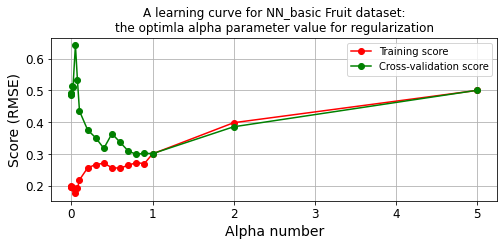

In [69]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.set_title('A learning curve for NN_basic Fruit dataset:\nthe optimla alpha parameter value for regularization')
ax.set_xlabel("Alpha number")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(alpha_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(alpha_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()

### Apply different activation functions (logistic, tanh, relu) and show the effect. 

C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\xiexi\anaconda3\envs\CPSC5610\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to c

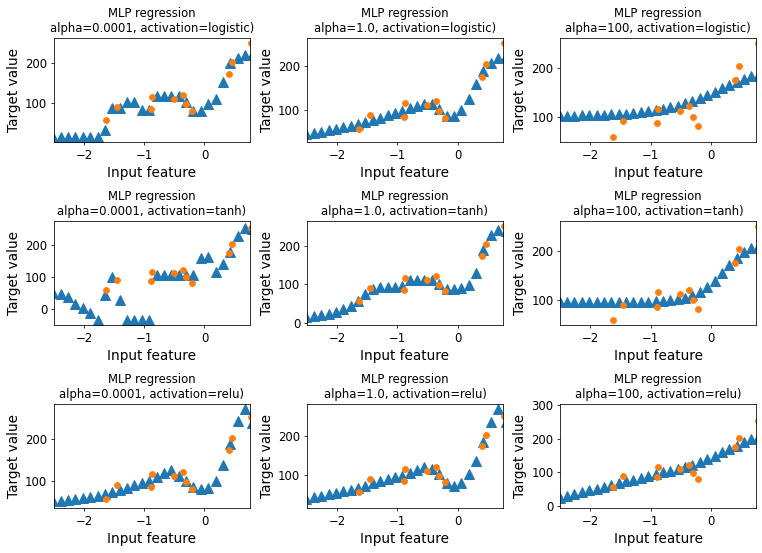

In [57]:
from sklearn.neural_network import MLPRegressor

fig, subaxes = plt.subplots(3, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['logistic','tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()

### Compare the results without scaling and with scaling. 

In [94]:
col = ['alpha_sizes','train_scores-test_scores']
alpha_sizes = [0, 0.0001, 0.001, 0.01, 0.02, 0.05, 0.075, 0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7,0.8,0.9, 1,2,5]
for ar in col:
    print(f"{ar}", end="\t")
count =0
print()
for ar in alpha_sizes:
    print(f"{ar}\t\t{train_scores_mean[count]-test_scores_mean[count]}", end="\n ")
    count +=1
print()

alpha_sizes	train_scores-test_scores	
0		-0.2845755565319724
 0.0001		-0.2918586710547131
 0.001		-0.2957972844524387
 0.01		-0.3178764095981922
 0.02		-0.31684181987000093
 0.05		-0.46585201798481046
 0.075		-0.33946323189318756
 0.1		-0.21622307808323954
 0.2		-0.11950403556434497
 0.3		-0.08398250837856602
 0.4		-0.04692900050841514
 0.5		-0.1067802122996433
 0.6		-0.08163931098697003
 0.7		-0.04472559383902386
 0.8		-0.02609356827449022
 0.9		-0.0325214730680925
 1		-0.0007032498740234816
 2		0.012786947010501037
 5		-0.00035580012517960613
 


####  Compared: 
When alpha =0, Test_scores>> Trainning_scores, indicated the model is underfitting. When the alpha increase the value, training scores slowly close with testing score. When alpha=1, trainning score is very close to testing score, the model have best performance.

## Part 2

- Write a short summary of your analysis result of neural networks (submitted on Canvas). 

- Provide a link to the notebook on Github.